# Vectors & word embeddings 
A workshop by UMN LATIS and the Libraries. 

Portions of the [Constellate's TAP Institute Introduction to Vector Databases and Semantic Searching](https://github.com/wjbmattingly/tap-2024-vector-databases?ref=cms-prod.constellate.org), [the Carpentries' Text Analysis in Python](https://carpentries-incubator.github.io/python-text-analysis/), and [UC Berkeley D-Lab's Text Analysis](https://github.com/dlab-berkeley/Python-Text-Analysis/tree/main) lessons are re-used in this lesson. These lessons are licensed under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) as is the content presented below.  

## What we'll cover in this session
    - Representing words as numbers
    - TF-IDF
    - Word vectors
    - What are they? 
    - How they work + Benefits
    - Word Vectors with Spacy
    - Interpreting results
    - Word embeddings in 2d plots
    - Calculating distance between pairs
    - Semantic Search
        - Document embedding
    - Transformers


## Install required libraries
If you're working from your own machine you can use pip install to make sure you have downloaded all of the Python packages you'll need to use today. 

If you're working on notebooks.latis.umn.edu, there's no need to install any of these, since they're included in the virtual environment.

In [ ]:
# use !pip install to install libraries we'll use today
# numpy 2 does not work with sentence-transformers
#!pip install spacy scikit-learn pandas matplotlib 'numpy<2' 
 
# or use conda
#!conda install spacy scikit-learn pandas numpy matplotlib 'numpy<2'

# This command downloads the medium-sized English language model for spaCy.
# It uses the Python module-running option to run spaCy's download command for the "en_core_web_md" model.
#!python -m spacy download en_core_web_md 

## Changing words into numbers
- Computers require numerical representations of things like images and words to be able to store, process, and manipulate them. 
- For most text analysis methods that will allows us to work with text as data, then, it's critical to use structured formats that represent words as numbers.
- At the base level computers already use encoding standards like Unicode to represent words as numbers, but Unicode represents specific characters in numerical form, not entire words. Since we're interested in working with the meanings of words and not characters, we'll use other methods to create numerical representations of our texts.
- Rather than manually assigning words to specific numbers on our own, we can utilize existing vector frameworks to transform our texts to numerical formats that allow us to analyze meaning.

## The Bag-of-Words Representation

The idea of bag-of-words (BoW), as the name suggests, is quite intuitive: we take a document and toss it in a bag. The action of "throwing" the document in a bag disregards relative position between words, so what is "in the bag" is essentially an unsorted set of words [(Jurafsky & Martin, 2024, p.62)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). In return, we have a list of unique words and the frequency of each of them. 

For example, as shown in the following illustration, the word "coffee" appears twice. 

<img src='bow-illustration-1.png' alt="BoW-Part2" width="600">

As you may have realized now, with a bag-of-words representation, we make heavy use of word frequency but not too much of word order. 

In the context of sentiment analysis, the sentiment of a tweet is conveyed more strongly by specific words. For example, if a tweet contains the word "happy", it likely conveys positive sentiment, but not always (e.g., "not happy" denotes the opposite sentiment). When these words come up more often, they'll probably more strongly convey the sentiment.

## Document Term Matrix

Now let's implement the idea of bag-of-words. Before we go deep into that, let's step back for a moment. In practice, text analysis often involves handling many documents; from now on, we use the term **document** to indicate a piece of text that we perform analysis on. It could be a phrase, a sentence, a tweet, and etc, as long as it could be represented by a string of text, the length dosen't really matter. 

Imagine we have four documents (i.e., the four phrases shown above), we toss them all in the bag. Instead of a word-frequency list, we would expect a document-term matrix (DTM) in return. In a DTM, the word list is the **vocabulary** (V) that holds all unique words occur across the documents. For each **document** (D), we count the number of occurence of each word in the vocabulary, and then plug the number into the matrix. In other words, the DTM we will need to construct is a $D \times V$ matrix, where each row corresponds to a document, and each column corresponds to a token (or "term").

In the following example, the unique tokens in this set of documents, in alphabetical order, are in columns. For each document, we mark the occurence of each word showing up in the document. The numerical representation for each document is a row in the matrix. For example, "the coffee roaster" or the first document has numerical representation $[0, 1, 0, 0, 0, 1, 1, 0]$.

Note that the left index column now displays these documents as texts, but typically we would just assign an index to each of them. 

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

To create a DTM, we will use `CountVectorizer` from the package `sklearn`.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

Let's use our toy example to take a closer look.

The first step is to initialize a CountVectorizer object. Within the round paratheses is the parameter setting we may choose to specify. Let's take a look at the documentation and see what options are available.

For now we can just leave it blank for the default setting.

In [2]:
# A toy example containing four documents (phrases)
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

# Create a CountVectorizer object
vectorizer = CountVectorizer()

The second step is to `fit` this `CountVectorizer` object to the data, which means creating a vocabulary of tokens from the set of documents. Thirdly, we `transform` our data according to the "fitted" `CountVectorizer` object, which means taking each of the document and transforming it into a DTM according to the vocabulary established by the "fitting" step.

It may sound a bit complex but steps 2 and 3 can actually be done in one swoop using a `fit_transform` function.

In [3]:
# Fit and transform to create DTM
test_count = vectorizer.fit_transform(test)
test_count

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

Apparently the return is a "sparse matrix"—a matrix that contains a lot zeros. It actually makes sense. For each document we definitely have words that don't occur at all, which are counted zero in the DTM. This sparse matrix is stored in a "Compressed Sparse Row" format, which is a memory-saving format that is designed to deal with sparse matrix. 

Let's convert it to a dense matrix, where those zeros are probably organized, as in a numpy array.

In [4]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

So this is our DTM! It is the same as shown above, but to make it more reader-friendly, let's convert it to a dataframe. The column names should be tokens in the vocabulary, which we can access with `get_feature_names_out()`.

In [5]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [6]:
import pandas as pd
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

In [7]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


### TF-IDF: Term Frequency, Inverse Document Frequency

- TF-IDF is a statistical measure using a matrix to evaluate how important a word is to a document or corpus. 
- In a TF-IDF matrix:
    - each row represents a document
    - each column represents a unique word
    - each cell contains a score for that word in the document
 
The score increases relative to the number of times that a word appears in a document, offset by its frequency in the entire corpus. So words that are more common across the entire corpus will have lower scores in a particular document, which helps us account for common terms. 

Let's use the spacy package to transform a collection of State of the Union addresses into a TF-IDF Document Term Matrix.

#### Import required libraries

In [8]:
import spacy
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
# note that we installed numpy 1.* since 2 does not work with the sentence-transformers package we work with later in the lesson
import numpy as np

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

In [9]:
# create three simple documents
#document = ['feed the duck', 'feed the goose', 'duck duck goose']

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Convert a collection of raw documents to a matrix of TF-IDF features.
tfidf_matrix = vectorizer.fit_transform(test)

# Create a DataFrame for better readability
df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df

,americano,coffee,iced,light,roast,roaster,the,time
0,0.000000,0.486934,0.000000,0.000000,0.000000,0.617614,0.617614,0.000000
1,0.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000
2,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.619130,0.000000,0.000000,0.000000,0.000000,0.000000,0.785288


In [10]:
test

['the coffee roaster', 'light roast', 'iced americano', 'coffee time']

- Each row is a document (e.g., row 0 is "the coffee roaster"). 
- Each column is a word in our list of documents. 
- Each cell has a score for the word that increases relative to the number of times that a word appears in a document, offset by its frequency in the entire corpus.

You can type in the name of the class and Shift+Tab to get a pop up with the documentation for `TfidfVectorizer` to look into more options you could explore for creating TF-IDF matrices.

In [11]:
TfidfVectorizer

sklearn.feature_extraction.text.TfidfVectorizer

#### Tokenize the SOTU corpus with spacy

In [12]:
# Collect all speech file paths
sotu = glob.glob("../sotu_kaggle/*.txt")

For those of you who made it to the Text as Data intro workshop, this will be some review. In short, we'll create a function to read in each speech as an item in a list called `processed_speeches`.

In [13]:
def tokenize_speeches(speeches_glob, n):
    # Initialize a list to store preprocessed speeches
    processed_speeches = []
    
    # Process each speech
    for speech_path in speeches_glob[0:n]:
        with open(speech_path, 'r') as file:
            text = file.read()
    
            #tokenize each document using spacy
            doc = nlp(text)
            
            # Filter tokens and join them into a single string
            # ignore stop words, punctuation, spaces and digits
            tokens = [token.text.lower() for token in doc if not (token.is_stop or token.is_punct or token.is_space or token.is_digit or token.like_num)]
    
            # Re-join the list of tokens into a single string
            processed_text = ' '.join(tokens)
    
            # Append each cleaned and tokenized document to our list
            processed_speeches.append(processed_text)
            
    return processed_speeches

# let's just read in the first 5 speeches to start off
processed_speeches = tokenize_speeches(sotu, 5)

# look at the first 250 characters of the first speech, tokenized:
processed_speeches[0][0:250]

'mr. speaker mr. president distinguished members congress honored guests fellow citizens today marks state union address constitutional duty old republic president washington began tradition reminding nation destiny self government preservation sacred'

### Convert to a TF-IDF Vector


In [14]:
# We'll use the same vectorizer settings from before to
# Fit and transform the first 5 preprocessed speeches to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(processed_speeches)

In [15]:
# get the matrix shape: 5 rows, by 5,067 columns
# each row is a document, each column is a token
tfidf_matrix.shape

(5, 5067)

#### Use Pandas to view the matrix

In [16]:
# Create a DataFrame for better readability
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DataFrame
df_tfidf.head()

,13,19o8,22d,2d,abandon,abandoned,abandoning,abandonment,abiding,ability,...,years,yes,yield,yielding,york,young,zealous,zest,zone,zones
0,0.026757,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,...,0.076498,0.026757,0.000000,0.000000,0.000000,0.007537,0.000000,0.000000,0.000000,0.026757
1,0.000000,0.000000,0.000000,0.000000,0.008552,0.000000,0.0106,0.0106,0.000000,0.017104,...,0.025255,0.000000,0.000000,0.000000,0.000000,0.017915,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.020371,0.000000,...,0.038828,0.000000,0.016435,0.000000,0.000000,0.034430,0.000000,0.020371,0.000000,0.000000
3,0.000000,0.004182,0.004182,0.004182,0.003374,0.004182,0.0000,0.0000,0.000000,0.013497,...,0.055801,0.000000,0.003374,0.000000,0.008365,0.004713,0.004182,0.000000,0.033459,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,...,0.014461,0.000000,0.000000,0.030349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
# Number of top words to extract for each document
top_n = 5

# Find the top n words for each document
top_words_per_document = []
for index, row in df_tfidf.iterrows():
    top_words = row.sort_values(ascending=False).head(top_n).index.tolist()
    top_words_per_document.append(top_words)

# Print the top words for each document
for doc_index, words in enumerate(top_words_per_document):
    print(f"Document {doc_index + 1} top words:\n {words}\n")

Document 1 top words:
 ['programs', 'federal', 'tax', 'government', 'program']

Document 2 top words:
 ['congress', 'law', 'tariff', 'country', 'cable']

Document 3 top words:
 ['great', 'people', 'tasks', 'means', 'states']

Document 4 top words:
 ['government', 'statute', 'law', 'department', 'states']

Document 5 top words:
 ['enemy', 'war', 'lake', 'american', 'great']



In TF-IDF the words are assigned numbers based on their importance to each document and the corpus, but the numbers don't actually tell us anything about a word's meaning or its relationship to other words. Words vectors give us a way to understand more about how words in a corpus relate to each other.

## Word Vectors

When people refer to word vectors, or word embeddings, they're talking about a way of representing each word as a numerical vector in a high-dimensional space, typically from 50 to 300 dimensions. 

Key properties of word vectors:

1. Dimensionality: In TF-IDF there as many dimensions as there are words in the vocabulary. Word vectors typically have fewer dimensions (e.g., 100 or 300).

2. Density: Unlike TF-IDF where a vector consists mostly of 0s, word vectors are dense, meaning most elements are non-zero.

3. Learned from data: Word vectors are typically learned from large text corpora using machine learning techniques. They capture semantic and syntactic relationships between words based on their usage patterns in the text. The relationships between the words come entirely from the text corpora they were trained on - not from your documents!

4. Semantic relationships: Similar words have similar vectors. For example, the vectors for "king" and "queen" might be close to each other.

5. Arithmetic operations: Word vectors often exhibit interesting arithmetic properties. A classic example is: vector("king") - vector("man") + vector("woman") ≈ vector("queen").

## How Word Vectors Work

Word vectors work on the principle of distributional semantics, which states that words that occur in similar contexts tend to have similar meanings. Machine learning models analyze large amounts of text data to learn these representations.

There are different popular models out there, such as Word2Vec, developed by Google. We'll stick with spaCy, and use the vector model that comes with "en_core_web_md".

For more information about how these models produce meaningful word embeddings, and how the models are trained, see the Carpentries' lesson on [the Word2Vec algorithm](https://carpentries-incubator.github.io/python-text-analysis/08-wordEmbed_word2vec-algorithm/index.html). 

In [18]:
# convert a word to an nlp() object 
token = nlp("freedom")
# save the nlp vector attribute for "freedom"
vector = token.vector

#the vector has 1 row and 300 columns, for each dimension
vector.shape

(300,)

The vector itself isn't very interesting.

In [19]:
# we'll reshape the numpy array
# -1 infers how many rows are needed and will resolve to 1 since we have a 1d vector
df = pd.DataFrame(vector.reshape(-1, len(vector)))
df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.62752,0.096647,0.058525,-0.041364,0.008209,0.1223,-0.37158,1.1244,-0.10964,2.6778,...,-0.56081,0.43747,-0.34792,-0.058516,-0.19365,0.32982,0.28227,0.10554,-0.75263,-0.24929


### Cosine Similarity
But we can compare different word vectors to measure their similarity, in terms of the mathematical differences between the vectors. We'll first use spaCy's similarity method.

It’s important to note that the effectiveness of the similarity measurement depends on the quality of the model's embeddings and whether the model has been trained on a relevant corpus for the task at hand.

In [20]:
def compare_words(word1, word2):
    similarity = nlp(word1).similarity(nlp(word2))
    print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

In [21]:
compare_words('king', 'president')
compare_words('king', 'pauper')
compare_words('president', 'pauper')

Similarity between 'king' and 'president': 0.3532
Similarity between 'king' and 'pauper': 0.0144
Similarity between 'president' and 'pauper': 0.1030


What does this tell us? It means that semantically and syntactically, king and president are used in more similar ways than king and pauper This is because the embeddings produced are the result of an embedding model that saw a lot of English texts and in those texts, kings and presidents are represented in similar ways, as you would expect. 

### Word embeddings on a 2d plot with PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while retaining as much of the variance (information) as possible.

Our original word vectors are in a high-dimensional space (e.g., 300 dimensions). But visualizing or analyzing high-dimensional data can be challenging. PCA helps reduce these 300 dimensions to a lower number (in this case, 2), making it easier to plot and interpret the relationships between words

In [22]:
words = ['nurse', 'doctor', 'farmer', 'athlete', 'librarian', 'teacher']

# create a vector for each word in a list called vectors
vectors = [nlp(word).vector for word in words]

# Reduce the dimensions of the vectors using Principal component analysis (PCA)
# We are choosing 2 compenents so we can plot them in a 2D space
pca = PCA(n_components = 2)
vectors_2d = pca.fit_transform(vectors)

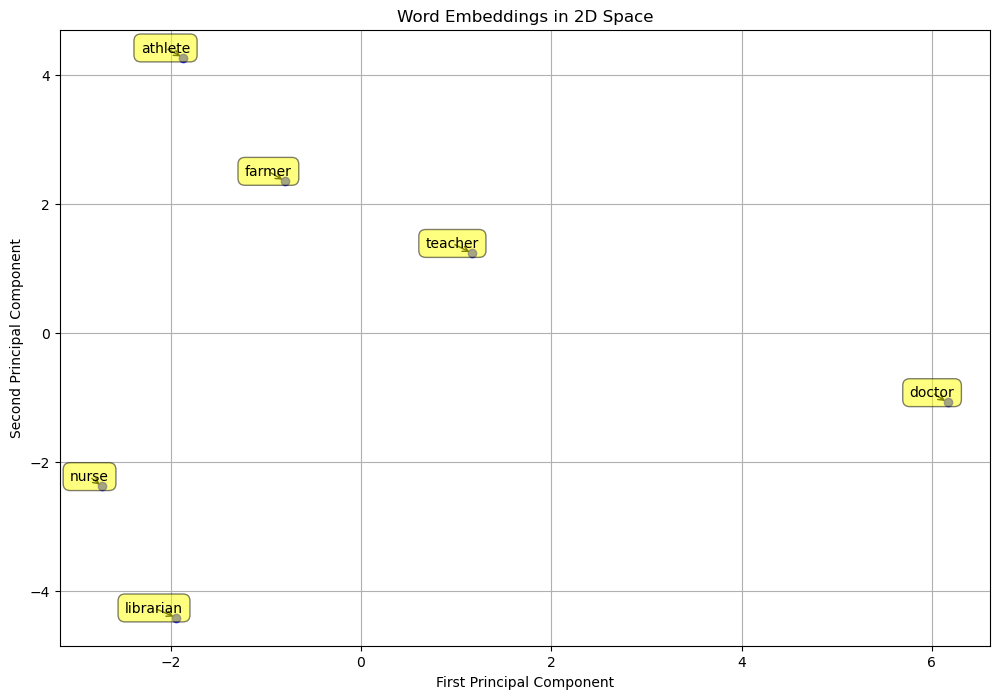

In [23]:
# Plot the words in 2D space
plt.figure(figsize=(12, 8))
# scatter plot with first column - the first PC x-coordinates - and 2nd column of array - 2nd PC y-coordinates
# c='b' color blue
# alpha=0.7 is transparency of points
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='b', alpha=0.7)

# xytext=(5, 2): offset of the annotation text - 5 points right, 2 points above
# ha is horizontal alignment
# va vertical
# bbox - properties of bounding box
# arrowprops - style of arrow annotating points

for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2), 
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title("Word Embeddings in 2D Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.grid(True)
plt.show()

#plt.savefig('../outputs/word_embeddings_2d.svg', format='svg')
#print("Plot saved as 'word_embeddings_2d.svg'")

This visualization helps us understand how word embeddings capture semantic relationships. Words with similar meanings or uses tend to cluster together in the vector space, while words with different meanings are farther apart. Even in this simplified 2D representation, we can see how the embedding space organizes words in a way that reflects their semantic relationships.

Remember, though, that this is a significant simplification of the original high-dimensional space. In the full embedding space, these relationships are even more nuanced and accurate.

### Euclidean Distance

The Euclidian distance formula makes use of the Pythagorean theorem, where $a^2 + b^2 = c^2$. We can draw a triangle between two points, and calculate the hypotenuse to find the distance. This distance formula works in two dimensions, but can also be generalized over as many dimensions as we want. 

In [24]:
# Calculate and print the Euclidean distances between pairs
print("\nDistances between pairs:")
for i in range(len(words)):
    # Loop through the remaining words (starting from the next word after i)
    for j in range(i+1, len(words)):
        # Calculate the Euclidean distance between the 2D vectors of word i and word j
        distance = np.linalg.norm(vectors_2d[i] - vectors_2d[j])
        # Print the distance between word i and word j with 4 decimal places
        print(f"{words[i]} - {words[j]}: {distance:.4f}")


Distances between pairs:
nurse - doctor: 8.9795
nurse - farmer: 5.1067
nurse - athlete: 6.6988
nurse - librarian: 2.1792
nurse - teacher: 5.3086
doctor - farmer: 7.7625
doctor - athlete: 9.6467
doctor - librarian: 8.7666
doctor - teacher: 5.5056
farmer - athlete: 2.1909
farmer - librarian: 6.8630
farmer - teacher: 2.2624
athlete - librarian: 8.6802
athlete - teacher: 4.2892
librarian - teacher: 6.4493


## Semantic search & vector databases
In this section we will create a vector database with many State of the Union documents, and query it semantically. 

### What are Vector Databases?
Vector databases are specialized storage and retrieval systems designed to handle high-dimensional vector data efficiently. Unlike traditional databases that work with structured data like numbers and text, vector databases are optimized for managing and querying vector embeddings - numerical representations of data points in a multi-dimensional space.

At their core, vector databases address the challenge of similarity search in large datasets. They excel at finding the most similar items to a given query, which is crucial for applications like recommendation systems, image recognition, and natural language processing. For instance, in a vector database storing product information, you could easily find similar products based on various attributes, all encoded as vectors.

The key advantage of vector databases lies in their ability to perform fast approximate nearest neighbor (ANN) searches. Traditional databases might struggle with the "curse of dimensionality" when dealing with high-dimensional data, but vector databases employ specialized indexing techniques to maintain efficiency. This makes them particularly useful for AI and machine learning applications, where data is often represented in high-dimensional vector spaces.

For those new to the concept, you can think of a vector database as a system that organizes information in a way that mirrors how our brains associate related concepts. Just as we can quickly recall words or images that are similar to a given prompt, vector databases can rapidly retrieve data points that are "close" to each other in a mathematical sense. This capability opens up exciting possibilities for creating more intelligent and intuitive data-driven applications across various domains.

In [25]:
# Using !pip install
#!pip install annoy txtai sentence-transformers rank-bm25

# or conda
#!conda install python-annoy txtai sentence-transformers
#!pip install rank-bm25

In [26]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch
from annoy import AnnoyIndex
from rank_bm25 import BM25Okapi

Here's how you can load all of the sotu speeches into an unprocessed and untokenized list. We are going to just load these in via a pickle file to save the load on the notebooks server...

In [27]:
# sotu_kaggle = glob.glob("../sotu_kaggle/*.txt")

# # use a dictionary so we can keep track of the filenames
# speeches = {}
# for speech in sorted(sotu_kaggle):
#     with open(speech, 'r') as file:
#         speech = speech.lstrip('../sotu_kaggle/')[:-4]
#         speeches[speech] = file.read() 

# # convert the dictionary to a df
# df = pd.DataFrame(speeches.items(), columns=['name_year', 'text'])   
# df.head()

# # split name_date column by delimiter
# df[['name','year']] = df['name_year'].str.split('_',expand=True)
# df = df.drop('name_year', axis=1)
# df.head()

In [34]:
with open('sotu.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(10)

,text,name,year
0,Gentlemen of the Senate and Gentlemen of the H...,Adams,1797
1,Gentlemen of the Senate and Gentlemen of the H...,Adams,1798
2,Gentlemen of the Senate and Gentlemen of the H...,Adams,1799
3,Gentlemen of the Senate and Gentlemen of the H...,Adams,1800
4,Fellow Citizens of the Senate and of the House...,Adams,1825
5,Fellow Citizens of the Senate and of the House...,Adams,1826
6,Fellow Citizens of the Senate and of the House...,Adams,1827
7,Fellow Citizens of the Senate and of the House...,Adams,1828
8,To the Senate and House of Representatives of ...,Arthur,1881
9,To the Senate and House of Representatives of ...,Arthur,1882


### Vectorize with sentence-transformers
Now that we have all our documents, it comes time to vectorize them, or convert them into a sequence of vectors. This is where we pass the texts to a machine learning model and capture the output vector for each of them. To do this, though, we need a model loaded. We will be using the sentence-transformers library. It makes this process as simple as possible with only two lines of code. First, we will need to load the model.

In [35]:
# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # This is a standard, efficient model

Now that we have loaded our model we can (optionally) specify the specific device. The code below will put it onto your GPU, if available. If you don't know if this is enabled on your device, then it likely is not. The steps to activate cuda are very specific and require you to install certain packages in a certain way. If you do not have cuda, then the default will be the cpu. With 236 documents, this will not be an issue.

In [36]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Let's encode the speeches! We can do that with a single line. I like to set show_progress_bar to True. We are going to skip this step on the notebooks server, and work from a saved pickle file with the embeddings. It took about 26 seconds for me locally to run.

In [37]:
#embeddings = model.encode(list(speeches.values()), show_progress_bar=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
# Load embeddings from the pickle file
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [39]:
#add embeddings 
df["embedding"] = list(embeddings)
df.head()

,text,name,year,embedding
0,Gentlemen of the Senate and Gentlemen of the H...,Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00..."
1,Gentlemen of the Senate and Gentlemen of the H...,Adams,1798,"[-0.028948274, -0.0046473336, -0.009841042, -0..."
2,Gentlemen of the Senate and Gentlemen of the H...,Adams,1799,"[-0.0013630837, 0.12678212, 0.05758622, -0.001..."
3,Gentlemen of the Senate and Gentlemen of the H...,Adams,1800,"[0.04068835, 0.08385914, 0.10812476, 0.0049056..."
4,Fellow Citizens of the Senate and of the House...,Adams,1825,"[-0.015273168, 0.089902245, -0.010282357, -0.0..."


In [ ]:
#now make the year column the index and resort by year
#df = df.set_index('year')
#df.sort_index(inplace=True)
#df

At this stage, we now have all the data necessary to create a vector database! 

### BM25
BM25 (Best Matching 25) is a ranking function used in information retrieval systems, particularly in search engines. It's an advanced form of TF-IDF (Term Frequency-Inverse Document Frequency) that provides a way to rank documents based on their relevance to a given search query.

BM25 improves upon simpler ranking methods by incorporating document length normalization. This means it can account for the fact that longer documents are more likely to contain a given term simply due to their length, rather than because of relevance.

The algorithm calculates a score for each document based on the query terms it contains. It considers both how often a term appears in a document (term frequency) and how rare the term is across all documents (inverse document frequency). However, it also applies a saturation function to prevent common terms from dominating the score.

For those new to information retrieval, BM25 can be thought of as a way of determining which documents in a collection are most relevant to a user's search query. It's widely used in practice due to its effectiveness and relatively simple implementation.

Now, let's look at how we can implement BM25 in Python using a DataFrame's 'speeches' field.

To do that, we first need to tokenize our text. We could use `nlp()` to use our spaCy model from earlier, but that would be quite time consuming. To save time let's just split our documents up by whitespace. 

In [40]:
tokenized_docs = []
for doc in df["text"]:
    split_doc = doc.split()
    # to use a slower but better tokenizer using spaCy:
    # split_doc = nlp(doc)
    tokenized_docs.append(split_doc)

Our BM250kapi tool expects each document to be a list of tokens though, and our current speeches are strings. So let's convert them to make processing easier.  

This single line of code will create a BM25 index for us! At this stage, we have essentially created a search engine index. 

In [41]:
bm25_index = BM25Okapi(tokenized_docs)

To query it, we need to create a query, tokenize the query, and then use the `get_scores()` method to retrieve the results. It's also best practice to sort these based on the scores. Finally, we can retrieve the results from the original DataFrame. In the cell below, we will have all the code necessary to perform these operations. I've done this so that you can more easily test this out with multiple queries. To understand what's happening in the code, though, let's breakdown each step here.

In [42]:
query = "Soviet Union"
tokenized_query = query.split()
doc_scores = bm25_index.get_scores(tokenized_query)
ranked_docs = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)[:5]

for idx, score in ranked_docs:
    print(f"Score: {score:.4f} - Speech {idx}: {df['year'][idx]} {df['name'][idx]}\n {df['text'][idx][0:250]}")
    print("-------------", "\n")

Score: 5.7038 - Speech 34: 1980 Carter
 This last few months has not been an easy time for any of us. As we meet
tonight, it has never been more clear that the state of our Union depends
on the state of the world. And tonight, as throughout our own generation,
freedom and peace in the worl
------------- 

Score: 5.3604 - Speech 204: 1951 Truman
 Mr. President, Mr. Speaker, Members of the Congress:

This 82d Congress faces as grave a task as any Congress in the history of
our Republic. The actions you take will be watched by the whole world.
These actions will measure the ability of a free pe
------------- 

Score: 5.2630 - Speech 206: 1953 Truman
 To the Congress of the United States:

I have the honor to report to the Congress on the state of the Union.

This is the eighth such report that, as President, I have been privileged
to present to you and to the country. On previous occasions, it ha
------------- 

Score: 5.2263 - Speech 33: 1979 Carter
 Tonight I want to examine in a broad 

- `query = "Soviet"`: This line defines the search query. 
- `tokenized_query = query.split()`: This line tokenizes the query string. The split() method without arguments splits the string on whitespace, creating a list of individual words. For our simple query, this results in ["Soviet", "Union"]. 
- `doc_scores = bm25_index.get_scores(tokenized_query)` - Use the pre-computed BM25 index (bm25_index) to score each document in the corpus based on the tokenized query.
- `get_scores()` method calculates a relevance score for each document in relation to the query.
- The result `doc_scores` is a list of floating-point numbers, where each number represents the relevance score of the corresponding document in the original corpus.

### Creating a Vector Database
Now that we have seen how to create a tradition text database and even learned to query it, let's compare these results to a vector database. To create our database, we will be using Annoy from Spotify. Annoy is a nearest neighbor algorithm that allows for us to easily and efficiently store millions of vectors in an index that we can then retrieve very efficiently. This is achieved by using a computationally efficient algorithm that is written in C. To use annoy, we first need to know the dimensions of our vectors. We can use `.shape` and examine index 1 to get our vector dimensions. Note, these will change from model to model.

In [43]:
vector_dim = embeddings.shape[1]
vector_dim

384

As we can see, we have a dimension of 384. Now that we know that, we can create our index which we will populate with vectors. When creating an AnnoyIndex, we need to specify two things: the number of vectors and the way in which want to measure similarity. We have a few options here. We are using angular.

```AnnoyIndex(f, metric) returns a new index that's read-write and stores vector of f dimensions. Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot". - Annoy docs```

In [44]:
annoy_index = AnnoyIndex(vector_dim, 'angular')

Now that we have created our index, it's time to populate it with data. When we do this, we need to use the `add_item()` method. This will take two arguments: the index number and the embedding itself. We can use enumerate() to create our i variable that will tick up by one each time we loop over our data. This is the equivalent of doing `i=i+1` inside our loop.

In [45]:
for i, embedding in enumerate(embeddings):
    annoy_index.add_item(i, embedding)

At this stage, our index has the data but it is not yet built. To build it, we can use the `build()` method. This will take 1 argument, the number of trees we want to use. In theory, the more trees, the better, but there's a point where you have diminished returns. Unless you are working with very complex data, 10 is usually a good starting number.

In [46]:
annoy_index.build(10)

True

In [47]:
query = "world war"
query_vector = model.encode(query)
similar_item_ids = annoy_index.get_nns_by_vector(query_vector, 5)

print(f"Search results for query: '{query}'")
print("------------------------------", "\n")

for idx, row in df.iloc[similar_item_ids].iterrows():
    print(f"Speech {df['year'][idx]} {df['name'][idx]}\n {df['text'][idx][0:250]}")
    print("-------------", "\n")

Search results for query: 'world war'
------------------------------ 

Speech 1943 Roosevelt
 Mr. Vice President, Mr. Speaker, Members of the Seventy-eighth Congress:

This Seventy-eighth Congress assembles in one of the great moments in the
history of the Nation. The past year was perhaps the most crucial for
modern civilization; the coming 
------------- 

Speech 1945 Roosevelt
 To the Congress:

In considering the State of the Union, the war and the peace that is to
follow are naturally uppermost in the minds of all of us.

This war must be waged--it is being waged--with the greatest and most
persistent intensity. Everythin
------------- 

Speech 1915 Wilson
 GENTLEMEN OF THE CONGRESS:

Since I last had the privilege of addressing you on the state of the Union
the war of nations on the other side of the sea, which had then only begun
to disclose its portentous proportions, has extended its threatening and
------------- 

Speech 1942 Roosevelt
 In fulfilling my duty to report upon th

### Chunking by sentence groups
This is nice but it would be much more useful if we could find matches from the most relevant sentences within each document. It's hard to see from these results if a speech is particularly relevant to our search or not.

To chunk our data into sentences, we'll first need to separate the text into sentences. To do that, we will use spaCy:

In [48]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

With this pipeline we can now chunk our data. In the cell below, we will be creating a new dataset from our original one while preserving the original index (document) index. We'll make chunks of the original data and also preserve the subindex for each chunk within the document. This means that for any given index in our chunked data, we have access to its position within the document to which it belongs and the corpus as a whole.

Let's skip running this code since it can take quite awhile (21 seconds on my machine). We can pre-load it from a saved pickle file instead.

In [49]:
# Function to chunk text into groups of 3 sentences
def chunk_text(text, chunk_size=3):
    # Use spaCy's NLP model to process the text and split it into sentences
    doc = nlp(text)
    # Convert the spaCy sentence objects into a list of sentences
    sentences = list(doc.sents)
    chunks = []
    # Loop over the sentences in steps of 'chunk_size' (default is 3)
    for i in range(0, len(sentences), chunk_size):
        # Extract a group of 'chunk_size' sentences
        chunk = sentences[i:i+chunk_size]
        # Join the sentences in the chunk into a single string and append to the 'chunks' list
        chunks.append(" ".join([sent.text for sent in chunk]))
    return chunks

# Create chunks
chunked_data = []
# tqtdm gives us a progess bar while we loop through our df
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Chunking texts"):
    # Apply the chunk_text function to the 'text' column of the current row 
    chunks = chunk_text(row['text'])
    # Loop through each chunk and keep track of its index within the document
    for chunk_idx, chunk in enumerate(chunks):
        # Convert the row's data to a dict
        chunk_data = row.to_dict()
        # Replace the 'text' field with the current chunk
        chunk_data['text'] = chunk
        # Add an index to keep track of which document this chunk belongs to
        chunk_data['document_index'] = idx
        # Add an index to keep track of the chunk's position within the document
        chunk_data['chunk_index'] = chunk_idx
        chunked_data.append(chunk_data)

# Create new DataFrame with chunks
chunked_df = pd.DataFrame(chunked_data)
chunked_df

Chunking texts: 100%|██████████| 228/228 [00:21<00:00, 10.44it/s]


In [52]:
with open('chunked_df.pkl', 'rb') as f:
    chunked_df = pickle.load(f)

chunked_df

,text,name,year,embedding,document_index,chunk_index
0,Gentlemen of the Senate and Gentlemen of the H...,Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00...",0,0
1,"I submit, however, to your consideration wheth...",Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00...",0,1
2,I have received\nintelligence of the arrival o...,Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00...",0,2
3,\n\nIt may be confidently asserted that nothin...,Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00...",0,3
4,The state\nof society has so long been disturb...,Adams,1797,"[-0.0030435165, 0.09838831, 0.075595096, -0.00...",0,4
...,...,...,...,...,...,...
20565,\n\nPermit me to emphasize once more the need ...,Wilson,1920,"[-0.022463989, 0.05254909, 0.0055605615, 0.023...",227,20
20566,"Indeed, It would be very serviceable to the pu...",Wilson,1920,"[-0.022463989, 0.05254909, 0.0055605615, 0.023...",227,21
20567,which difficulties are to be met and removed a...,Wilson,1920,"[-0.022463989, 0.05254909, 0.0055605615, 0.023...",227,22
20568,\n\nAllow me to call your attention to the fac...,Wilson,1920,"[-0.022463989, 0.05254909, 0.0055605615, 0.023...",227,23


Unfortunately, though, our embeddings are precisely the same for each chunk. This isn't good. We want new embeddings for each chunk. Let's go ahead and repeat the steps from earlier in the notebook. This will take quite a bit longer as we now have nearly 21,000 "documents". So, again, we'll skip this code to avoid the load to the server. This took a long time - about 12 minutes! - on my machine.

In [53]:
# Vectorize the chunks
# chunks = chunked_df['text'].tolist()
# chunk_embeddings = model.encode(chunks, show_progress_bar=True)

Batches:   0%|          | 0/643 [00:00<?, ?it/s]

In [54]:
# Load embeddings from the pickle file
with open('chunk_embeddings.pkl', 'rb') as f:
    chunk_embeddings = pickle.load(f)

In [55]:
# Replace the original embeddings with the new ones
chunked_df['embedding'] = list(chunk_embeddings)

In [56]:
# repeat the same indexing steps as above to create a searchable index on the chunks
annoy_index = AnnoyIndex(vector_dim, 'angular')
# Add items to the index
for i, embedding in enumerate(embeddings):
    annoy_index.add_item(i, embedding)
annoy_index.build(10)

True

Query the new index.

In [57]:
query = "warfare"
query_vector = model.encode(query)
similar_item_ids = annoy_index.get_nns_by_vector(query_vector, 5)

print(f"Search results for query: '{query}'")
print("------------------------------", "\n")
for idx, row in chunked_df.iloc[similar_item_ids].iterrows():
    print(f"Speech {chunked_df['year'][idx]} {chunked_df['name'][idx]}\n {chunked_df['text'][idx]}")
    print("-------------", "\n")

Search results for query: 'warfare'
------------------------------ 

Speech 1827 Adams
 

The expenditures of the year may perhaps amount to $22,300,000
presenting a small excess over the receipts. But of these $22,000,000,
upward of $6,000,000 have been applied to the discharge of the
principal of the public debt, the whole amount of which, approaching
$74,000,000 on January 1st, 1827, will on January 1st, 1828 fall short
of $67,500,000. The balance in the Treasury on January 1st, 1828 it is
expected will exceed $5,450,000, a sum exceeding that of January 1st,
1825, though falling short of that exhibited on January 1st, 1827.
------------- 

Speech 1826 Adams
 

JOHN QUINCY ADAMS
------------- 

Speech 1825 Adams
 It is with no feeling of
pride as an American that the remark may be made that on the
comparatively small territorial surface of Europe there are existing
upward of 130 of these light-houses of the skies, while throughout the
whole American hemisphere there is not one. If we

### More information
- [Transformers and LLMs](https://carpentries-incubator.github.io/python-text-analysis/10-finetuning-transformers/index.html)
- [The Word2Vec algorithm](https://carpentries-incubator.github.io/python-text-analysis/08-wordEmbed_word2vec-algorithm/index.html)